#Title: Predicting Customer propensity

####By: Bhavya Balasubramanya

###Data: This data is a part of Thinkful education and provides different insights to predict on the customer propensity

###Source: Datasets at Thinkful

###Link: https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv

###Variables:
 
**Unnamed:** This is the default index variable. <br>
**purch_amt:** This variable repesents money spent for purchaseand is a continuous variable.<br>
**gender:** This variable represents sex of the individual and is a categorical data.	<br>
**card_on_file:** This variable indicates if a person had a card on file or not and is a categorical data.<br>
**age:** This variable represents the age of the individual and is a continuous data.<br>
**days_since_last_purch:** This variable represents no of days past the last purchase and is a continuous data. <br>
**loyalty:** This variable represents the loyalty or propensity and is a categorical data. <br>


In [0]:
#import the required libraries to Visualize data and for statistical calculations.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import shuffle
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
#Import file from Datashare
file = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv'
data = pd.read_csv(file, encoding = "ISO-8859-1",low_memory=False)
data.head()


,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


## Understanding the data

In [3]:
#Let us inspect our data
data.shape

(120000, 7)

In [4]:
#Let us see the unique data types in our dataset
data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('bool')],
      dtype=object)

In [5]:
#Let us see the sats for object data type
data.describe(include=[np.object]).transpose()

,count,unique,top,freq
gender,120000,2,male,60181
card_on_file,120000,2,yes,60087


In [6]:
#Checking stats for integer data type variables
data.describe(include=[np.int]).transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120000.0,59999.5,34641.160489,0.0,29999.75,59999.5,89999.25,119999.0


In [7]:
#Checking stats for floating point data type variables
data.describe(include=[np.float]).transpose()

,count,mean,std,min,25%,50%,75%,max
purch_amt,120000.0,44.036234,20.473148,-43.95,30.21,43.97,57.83,142.2
age,120000.0,25.803008,10.153072,-22.00,19.00,26.00,33.00,71.0
days_since_last_purch,120000.0,56.605908,16.422187,-9.00,45.00,57.00,68.00,125.0


In [8]:
#Checking stats for boolean data type variables
data.describe(include=[np.bool]).transpose()

,count,unique,top,freq
loyalty,120000,2,False,100000


We will be predicting Loyalty , so let us see the loyalty distibution in our dataset

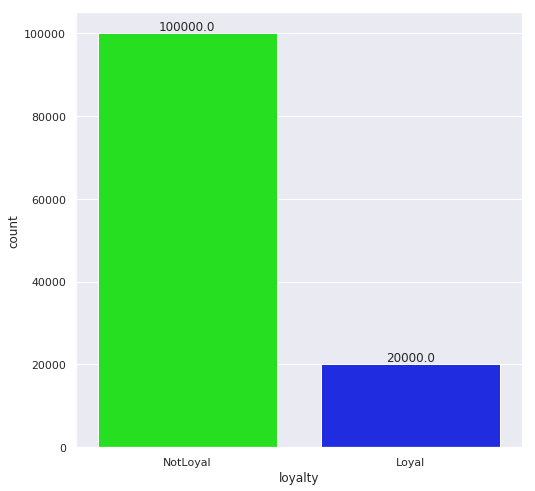

In [9]:
#Using countplot to measure the loyalty distribution
plt.figure(figsize=(8,8))
ax = sns.countplot(x='loyalty',data=data, palette = 'hsv')
for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{}'.format(y), (x.mean(), y), ha='center', va='bottom')
plt.xticks([0,1],["NotLoyal", "Loyal"])
plt.show()


From the above plot, we can see that the data is biased in the ratio 1:5 . We will try to balance the data during cleaning

## Data Cleaning

None of our data is missing, so let us try to balance the data using random undersampling method.

In [0]:
#Trying undersampling as amount of data is more

#taking count of rows that are  loyal
dflt = len(data[data.loyalty == True])
#Taking number of non loyal indicies
nodfltidx = data[data.loyalty == False].index

#taking 20000 rows by indices randomly
random_indices = np.random.choice(nodfltidx, dflt, replace=False)
#take indies of loyal data
dfltidx = data[data.loyalty == True].index
#take a combination of loyal and non loyal data
idx = np.concatenate([dfltidx,random_indices])
df = data.loc[idx]

In [11]:
df.shape


(40000, 7)

Since we don't need the first column (Unnamed), we can remove it

In [12]:
df = df.drop(df.columns[0], axis = 1).reset_index()
df.columns=['Idx','purch_amt','gender','card_on_file','age','days_since_last_purch','loyalty']
df = df.drop(columns = ['Idx'])
df.head(5)

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,93.63,female,no,40.0,47.0,True
1,64.91,male,yes,22.0,59.0,True
2,11.55,male,no,21.0,53.0,True
3,40.64,female,no,20.0,29.0,True
4,64.07,male,no,10.0,62.0,True


Dataset contains negative values for age, purchased amount and days since last purchase. So we need to correct the data so that only person aged 18 is allowed to purchase and the purchase amount can be 0 or above. Same goes for days since last purchased.

In [0]:
df = df.drop(df[df.age < 18].index)
df = df.drop(df[df.purch_amt <= 0].index)
df = df.drop(df[df.days_since_last_purch < 0].index)

Convert categorical data to indicator variables.

In [14]:
#Convert gender and card_on_file to binary data
dummy = pd.get_dummies(df[['gender','card_on_file']])
df = pd.concat([df,dummy],axis= 1) #Concatenate to 
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty,gender_female,gender_male,card_on_file_no,card_on_file_yes
0,93.63,female,no,40.0,47.0,True,1,0,1,0
1,64.91,male,yes,22.0,59.0,True,0,1,0,1
2,11.55,male,no,21.0,53.0,True,0,1,1,0
3,40.64,female,no,20.0,29.0,True,1,0,1,0
5,26.35,female,no,39.0,39.0,True,1,0,1,0


We can now convert our target to binary class variable

In [0]:
df['loyalty'] = df['loyalty'].astype(str).replace({'False':0, 'True':1})

In [16]:
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty,gender_female,gender_male,card_on_file_no,card_on_file_yes
0,93.63,female,no,40.0,47.0,1,1,0,1,0
1,64.91,male,yes,22.0,59.0,1,0,1,0,1
2,11.55,male,no,21.0,53.0,1,0,1,1,0
3,40.64,female,no,20.0,29.0,1,1,0,1,0
5,26.35,female,no,39.0,39.0,1,1,0,1,0


## Exploratory Data Analysis

**Let us try to see correlations within variables and with our target**

In [0]:
#Function for creating correlation Matrix and plotting heat maps which takes the dataframe, array of variables and string for category of variables
def correlations(df,arr,type):
  f, ax = plt.subplots(figsize=(12, 9))
  title = "Correlation for " + type
  plt.title(title)
  corrmat = df[arr].corr()
  corrmat.index = arr
  sns.heatmap(corrmat,annot=True,fmt='.2f',xticklabels=corrmat.columns,yticklabels=corrmat.columns,linewidths=.1,vmin =0,vmax=1, cmap="hsv", square=True)
  plt.show()

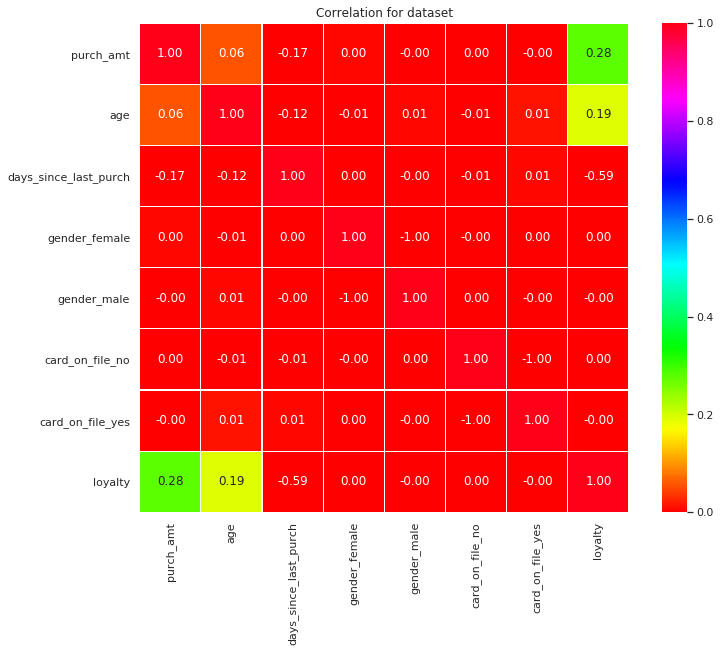

In [18]:
arr = ['purch_amt','age','days_since_last_purch','gender_female','gender_male','card_on_file_no','card_on_file_yes','loyalty']
correlations(df,arr,'dataset')

There are no correlations that exsits between the variables or with the target.


**Let us now see how the age is distributed between men and women**


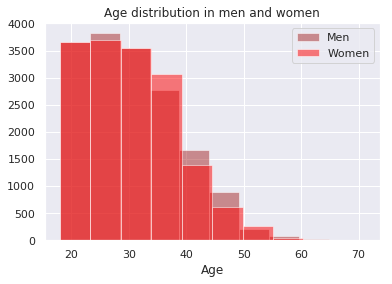

In [19]:
#Dataset for obtaining sex and age specific  blood pressures in people who had and didnt have symptoms upon waking.
menage = df.loc[(df['gender_male']==1),'age']
womenage = df.loc[(df['gender_female']==1),'age']

# Making overlapping histograms.
plt.hist(menage, color='brown',  alpha=.5,label='Men')  # alpha just controls the opacity
plt.hist(womenage, color='red', alpha=.5,label='Women')
plt.xlabel('Age')
plt.legend(loc='upper right')
plt.title('Age distribution in men and women')
plt.subplots_adjust(right=0.9)
plt.show()


We can see that the average age is between 25 to 35 in our dataset and that the average women is younger than average male. Our data is definitely skewed on the left side. Let us see the number of men and women in the dataset.

In [20]:
print("Number of men in the dataset : ",len(menage))
print("Number of women in the dataset : ",len(womenage))

Number of men in the dataset :  16665
Number of women in the dataset :  16290


**Is there a significant difference between the days since last purchase by people who have card on file vs people who dont?**

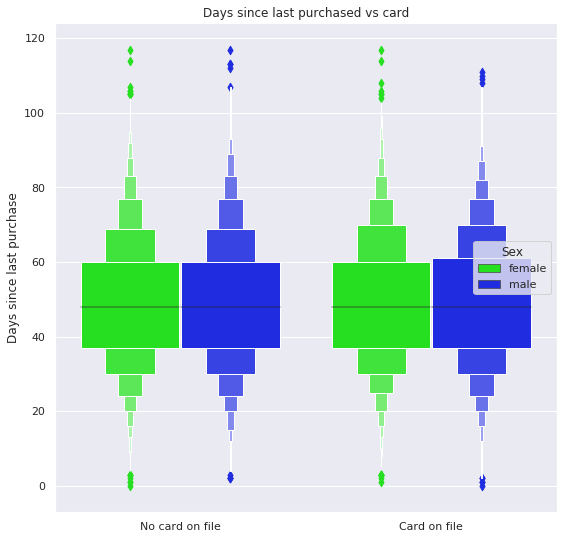

In [21]:
#using boxenplot to see the statistics
plt.figure(figsize=(9,9))

ax = sns.boxenplot(data=df, x='card_on_file', y='days_since_last_purch', hue='gender', palette='hsv' )
plt.xticks([0,1],["No card on file", "Card on file"])
plt.xlabel('')
plt.ylabel('Days since last purchase')
ax.legend(title="Sex")
plt.title("Days since last purchased vs card")
plt.show()

In [22]:
nocard = df.loc[(df['card_on_file_no']==1),'days_since_last_purch']
card = df.loc[(df['card_on_file_yes']==1),'days_since_last_purch'] 
print("Ttest for shopping trend with and without card on file: ",ttest_ind(nocard,card))

Ttest for shopping trend with and without card on file:  Ttest_indResult(statistic=-0.9470372777038938, pvalue=0.34362672820433404)


We can see that there was no significance in purchase dates for people having card on files vs people who didn't.



<br>



**Who spent more on purchases, men or women?**

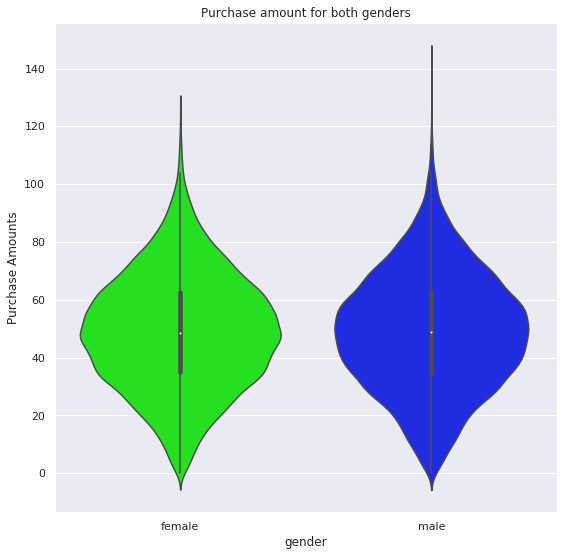

In [23]:
plt.figure(figsize=(9,9))

ax = sns.violinplot(data=df, x='gender',y='purch_amt', palette='hsv' )
plt.ylabel("Purchase Amounts")
plt.title("Purchase amount for both genders")
plt.show()

In [24]:
male = df.loc[(df['gender_male']==1),'purch_amt']
female = df.loc[(df['gender_female']==1),'purch_amt'] 
print("Ttest for men and women for purchase amounts: ",ttest_ind(male,female))

Ttest for men and women for purchase amounts:  Ttest_indResult(statistic=-0.7132883889903308, pvalue=0.47567237204545143)


Again there was no significant difference between the purchase amounts of men and women. Purchases look similar.

**What is the trend between the purchase amount and days since last purchased?**

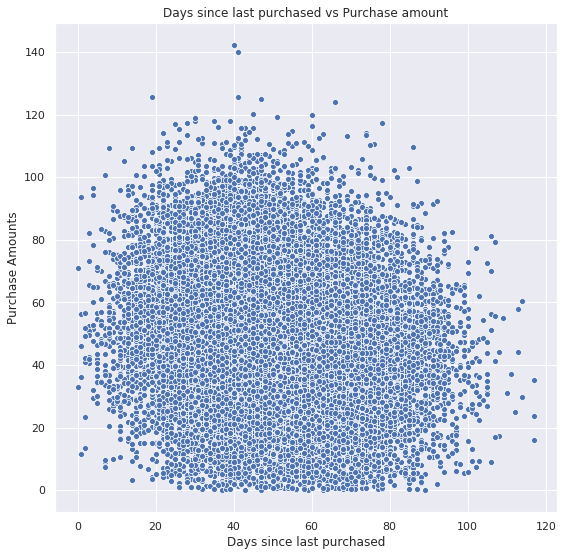

In [25]:
plt.figure(figsize=(9,9))

ax = sns.scatterplot(data=df, x='days_since_last_purch',y='purch_amt', palette='hsv' )
plt.ylabel("Purchase Amounts")
plt.xlabel("Days since last purchased")
plt.title("Days since last purchased vs Purchase amount")
plt.show()

There is no linear relationship between days since last purchased and purchase amount

## Feature Engineering

Let us try to add some features to our dataset. We will take log of age since it is not normally distributed. We will also square the amount and add weeks since last purchased.

In [0]:
df['age_log'] = np.log(df['age'])
df['amtsqr'] = df['purch_amt'] * df['purch_amt']
df['weeks_last_purch'] = df['days_since_last_purch']/7

Let us see correlations of feature engineered variables with target.

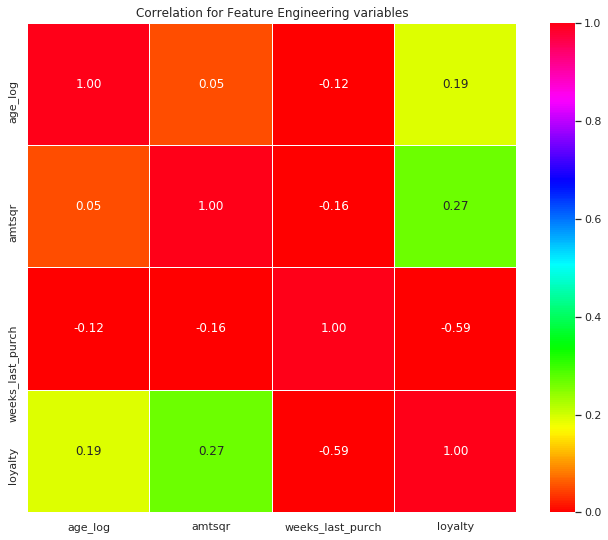

In [27]:
arr = ['age_log','amtsqr','weeks_last_purch','loyalty']
correlations(df,arr,'Feature Engineering variables')

## Unsupervised learning- PCA

In [0]:
#adding key variable which will helo us merge PCA components with the dataframe.
df['Key'] = ''

for i in range(len(df)):
    df['Key'].values[i] = i

In [0]:
#Generic Function to calculate PCA
def pca_loop(arr):
  pca = PCA()
  pcaarr = arr
  pcax = pca.fit_transform(arr)
  print("Explained Variance ratio of PCA components", pca.explained_variance_ratio_) 
  return pcax

In [30]:
#Calculate PCA for all variables except categorical and key indicator
pcaall = df.drop(['loyalty','gender','card_on_file','Key'],1)
pca = pca_loop(pcaall)

Explained Variance ratio of PCA components [9.99913202e-01 6.57206056e-05 1.46672912e-05 6.18354406e-06
 1.13337518e-07 1.12708010e-07 3.65670423e-10 1.03921973e-37
 3.99579271e-40 7.01059323e-41]


So the first PCA component explains most of the data. Let us see if we can find which variables constitute PCA component and correlations of PCA component with target.

In [0]:
pcadf = pd.DataFrame(pca[:,0],columns=['Comp'])

pcadf['Key'] = ''

for i in range(len(pcadf)):
    pcadf['Key'].values[i] = i

In [0]:
#Merge PCA data with rest of data
predict = pd.merge(df,pcadf,how='inner',on='Key')

Using heatmap to find correlations with PCA component

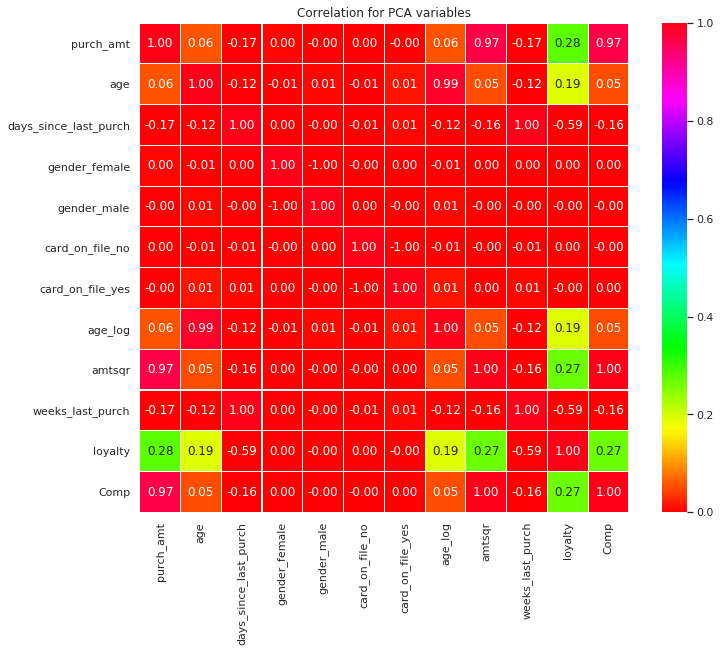

In [33]:
arr = ['purch_amt','age','days_since_last_purch','gender_female','gender_male','card_on_file_no',
       'card_on_file_yes','age_log','amtsqr','weeks_last_purch','loyalty','Comp']
correlations(predict,arr,'PCA variables')

Even though there is no clear contributor for PCA component, we can see that it is correlated with the target.

#Supervised Modelling

Now we will try to model our data to provide predictions. We will be using PCA  and feature engineering variables to predict our target. 

In [34]:
#Check the data now
predict.shape

(32955, 15)

In [0]:
#Shuffle dataset
predict = shuffle(predict)

In [0]:
#Define test and train sets
X = predict[['age_log','amtsqr','weeks_last_purch','Comp']]
y = predict[['loyalty']]

#Use offset for equal distributions
offset = 16496

train = predict[['age_log','amtsqr','weeks_last_purch','Comp','loyalty']][:offset]
test = predict[['age_log','amtsqr','weeks_last_purch','Comp']][offset+1:]
x_train, x_test = X[:offset], X[offset+1:] 
y_train, y_test = y[:offset], y[offset+1:] 

In [0]:
#Get the classes for target variable
le = LabelEncoder().fit(predict.loyalty) 
labels = le.transform(train.loyalty)           
classes = list(le.classes_)  

In [0]:
#Function for evaluating confusion matrix
def conmatplot(var):
  plt.figure(figsize = (6,4))
  plt.clf()
  plt.imshow(var, interpolation='nearest', cmap='hsv')
  classNames = ['Not Loyal','Loyal']
  plt.title('Confusion Matrix - Test Data')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]

  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center')
  plt.show()

KNeighborsClassifier
****Results****
Accuracy: 71.7523%
Cross validation scores: [0.69515152 0.71030303 0.69242424 0.69345058 0.69860522]
Average accuracy of cross validation: 0.70 (+/- 0.01)
Log Loss: 3.225980693845304


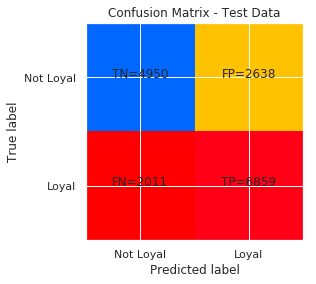

SVC
****Results****
Accuracy: 53.8948%
Cross validation scores: [0.53939394 0.53939394 0.53939394 0.53941783 0.53941783]
Average accuracy of cross validation: 0.54 (+/- 0.00)
Log Loss: 0.5934234983072706


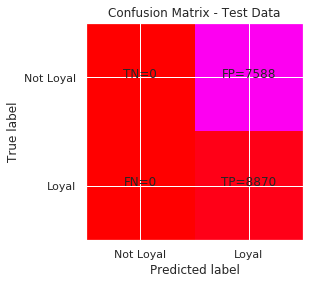

SGDClassifier
****Results****
Accuracy: 41.0560%
Cross validation scores: [0.39787879 0.46727273 0.53939394 0.6206792  0.60582171]
Average accuracy of cross validation: 0.53 (+/- 0.17)
Log Loss: 20.358528977441157


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


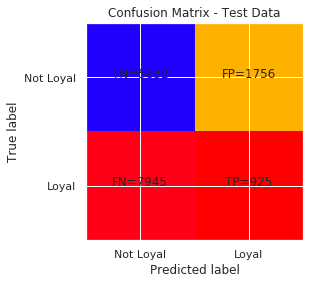

DecisionTreeClassifier
****Results****
Accuracy: 70.7255%
Cross validation scores: [0.72060606 0.71121212 0.72181818 0.70952092 0.70497271]
Average accuracy of cross validation: 0.71 (+/- 0.01)
Log Loss: 10.109214046504322


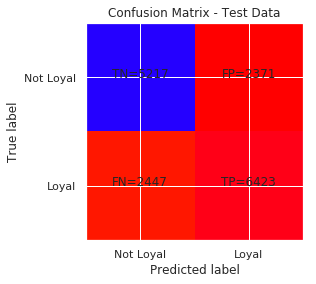

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier
****Results****
Accuracy: 75.3129%


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

Cross validation scores: [0.74454545 0.75727273 0.76575758 0.74287447 0.75894482]
Average accuracy of cross validation: 0.75 (+/- 0.02)
Log Loss: 1.6138074934440625


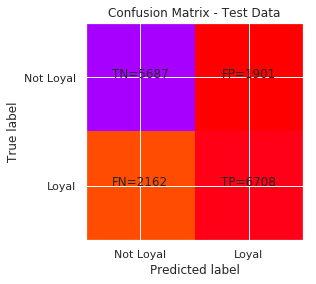

AdaBoostClassifier
****Results****
Accuracy: 79.1773%
Cross validation scores: [0.78787879 0.79787879 0.79757576 0.78532444 0.79229836]
Average accuracy of cross validation: 0.79 (+/- 0.01)
Log Loss: 0.6736108525608647


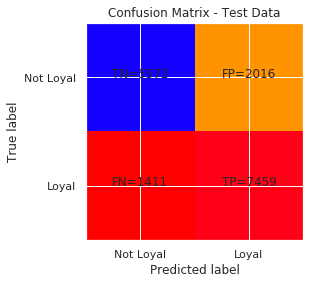

GradientBoostingClassifier
****Results****
Accuracy: 79.5601%
Cross validation scores: [0.78757576 0.80272727 0.79757576 0.78775015 0.797453  ]
Average accuracy of cross validation: 0.79 (+/- 0.01)
Log Loss: 0.44407013129969686


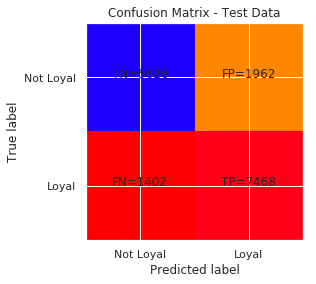

GaussianNB
****Results****
Accuracy: 78.0472%
Cross validation scores: [0.77636364 0.78575758 0.78181818 0.77501516 0.77956337]
Average accuracy of cross validation: 0.78 (+/- 0.01)
Log Loss: 0.5025886180701272


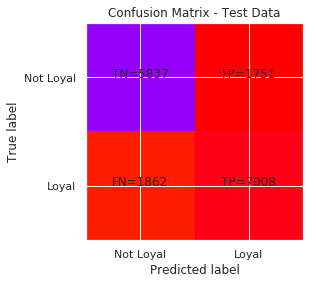

LinearDiscriminantAnalysis
****Results****
Accuracy: 79.4082%
Cross validation scores: [0.78787879 0.80393939 0.80212121 0.79017586 0.79775622]
Average accuracy of cross validation: 0.80 (+/- 0.01)
Log Loss: 0.4432522103834294


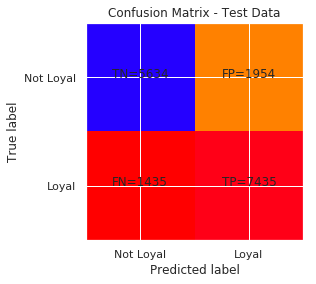

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 78.3449%
Cross validation scores: [0.77484848 0.79       0.78909091 0.77258945 0.78714372]
Average accuracy of cross validation: 0.78 (+/- 0.01)
Log Loss: 0.5217383136810166


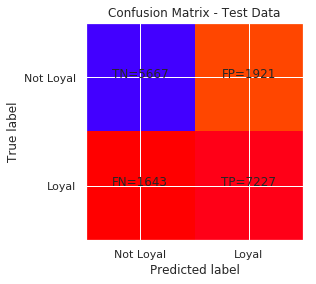

In [40]:
#Try modelling using the 10 different classification models
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    SGDClassifier(loss="log",penalty="l2", max_iter=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
       
    print('****Results****')
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= cross_val_score(clf, x_train, y_train, cv=5)
    print("Cross validation scores: {}".format(cv))
    print("Average accuracy of cross validation: %0.2f (+/- %0.2f)" % (cv.mean(), cv.std() * 2))
    
    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    cm = confusion_matrix(y_test, y_pred)
    conmatplot(cm)
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

## Best Model

Let us compare the models to determine the best model

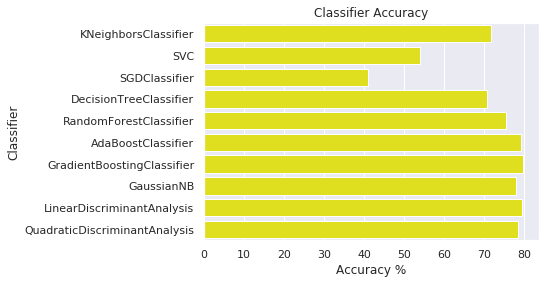

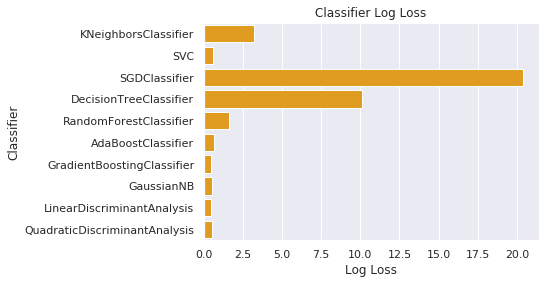

In [41]:
#Visualize accuracy and loss for all model
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="yellow")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="orange")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [42]:
#Print out the dataframe having Accuracy and Losses for each model.
log

,Classifier,Accuracy,Log Loss
0,KNeighborsClassifier,71.752339,3.225981
0,SVC,53.894762,0.593423
0,SGDClassifier,41.056021,20.358529
0,DecisionTreeClassifier,70.725483,10.109214
0,RandomForestClassifier,75.312918,1.613807
0,AdaBoostClassifier,79.177300,0.673611
0,GradientBoostingClassifier,79.560092,0.444070
0,GaussianNB,78.047150,0.502589
0,LinearDiscriminantAnalysis,79.408191,0.443252
0,QuadraticDiscriminantAnalysis,78.344878,0.521738


In [44]:
#Predict classes for the target
# Predict Test Set
favorite_clf = LinearDiscriminantAnalysis()
favorite_clf.fit(x_train, y_train)
test_predictions = favorite_clf.predict_proba(test)

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.reset_index()

NotLoyal = submission[0].median()
Loyal = submission[1].median()

# Export Submission
print("Average prediction of not being loyal: ", NotLoyal)
print("Average prediction of being loyal: ", Loyal)

Average prediction of not being loyal:  0.4006346796330167
Average prediction of being loyal:  0.5993653203669833


#Conclusion

Linear discriminent was best model and was very close to Gradient Boost and Ada Boost in terms of accouracy, log loss and cross validation. So we choose that as best model.
We can see that average predictions indicate that the chances of being loyal was more than not being loyal by 60:40 ratio.

For next steps we can try more feature engineering techniques and see how the predictions vary.